In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor

In [132]:
#
# load the data
#
df = pd.read_csv('synth_temp.csv')

In [133]:
#
# slice 1902 and forward
#
df = df.loc[df.Year > 1901]

In [134]:
#
# roll up by year
#
df_group_year = df.groupby(['Year']).agg({'RgnAvTemp' : 'mean'})

In [135]:
#
# add the Year column so we can use that in a model
#
df_group_year['Year'] = df_group_year.index
df_group_year = df_group_year.rename(columns = {'RgnAvTemp' : 'AvTemp'})

In [136]:
#
# scale the data
#
X_min = df_group_year.Year.min()
X_range = df_group_year.Year.max() - df_group_year.Year.min()
Y_min = df_group_year.AvTemp.min()
Y_range = df_group_year.AvTemp.max() - df_group_year.AvTemp.min()
scale_X = (df_group_year.Year - X_min) / X_range
#
train_X = scale_X.ravel()
train_Y = ((df_group_year.AvTemp - Y_min) / Y_range).ravel()

In [137]:
#
# create the model object
#
model = SGDRegressor(
    loss = 'squared_loss',
    max_iter = 1000000,
    learning_rate = 'constant',
    eta0 = 1e-6,
    tol = 1e-7,
    random_state = 42,
    penalty = 'none')

In [138]:
#
# fit the model
#
model.fit(train_X.reshape((-1, 1)), train_Y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=1e-06, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000000,
             n_iter_no_change=5, penalty='none', power_t=0.25, random_state=42,
             shuffle=True, tol=1e-07, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [139]:
Theta0 = (Y_min + Y_range * model.intercept_[0] - 
          Y_range * model.coef_[0] * X_min / X_range)
Theta1 = Y_range * model.coef_[0] / X_range
print(Theta0)
print(Theta1)

-7.082661463856759
0.012907035481800522


In [140]:
#
# generate predictions
#
pred_X = df_group_year['Year']
pred_Y = model.predict(train_X.reshape((-1, 1)))

In [141]:
#
# calcualte the r squared value
#
r2 = r2_score(train_Y, y_pred)
print('r squared = ', r2)

r squared =  0.22972942438279398


In [142]:
#
# scale predictions back to real values
#
pred_Y = (pred_Y * Y_range) + Y_min

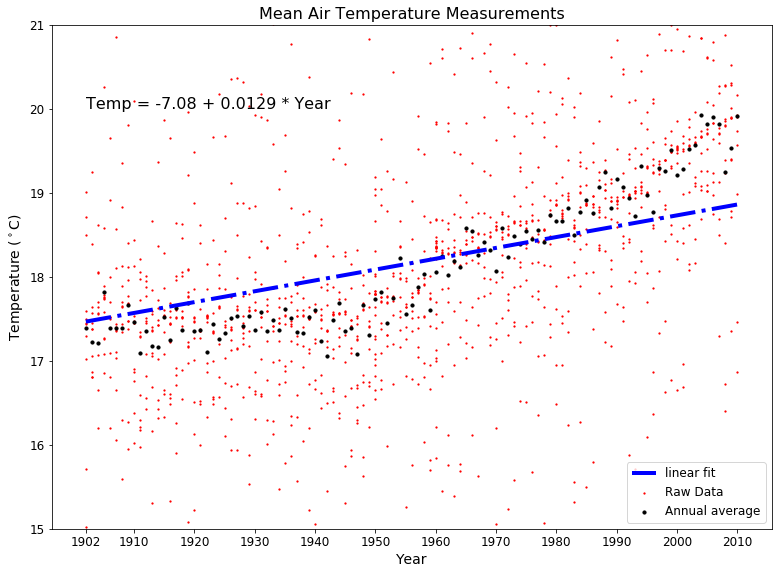

In [143]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
# Raw data
#
raw_plot_data = df
ax.scatter(raw_plot_data.Year, 
           raw_plot_data.RgnAvTemp, 
           label = 'Raw Data', 
           c = 'red',
           s = 1.5)
#
# Annual averages
#
ax.scatter(df_group_year.Year, 
           df_group_year.AvTemp, 
           label = 'Annual average', 
           c = 'k',
           s = 10)
#
# linear fit
#
ax.plot(pred_X, pred_Y, 
        c = "blue",
        linestyle = '-.',
        linewidth = 4,
        label = 'linear fit')
#
# put the model on the plot
#
ax.text(1902, 20,
        'Temp = ' + 
        str(round(Theta0, 2)) +
        ' + ' +
        str(round(Theta1, 4)) +
        ' * Year',
       fontsize = 16)
#
ax.set_title('Mean Air Temperature Measurements',
             fontsize = 16)
#
# make the ticks include the first and last years
#
tick_years = [1902] + list(range(1910, 2011, 10))
ax.set_xlabel('Year', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$C)', 
              fontsize = 14)
ax.set_ylim(15, 21)
ax.set_xticks(tick_years)
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12)